# International Assessments in Python 🎓

In this notebook we: 
- read data from the latest edition of TIMSS (2019) 
- tranform it to the format suitable for working in Python
- perform basic exploratory analysis
- visualize the data

In [25]:
# Load necessary packages for data wrangling, analysis and visualization
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os
import glob

## I Reading and cleaning the data

In [12]:
# Throughout this analysis we rely on TIMSS data in STATA format (.dta) provided by Evidence Institut
# Please define your local path to the required input STATA files
path='./in/2019/'

In [91]:
# Grade 4 student context data files. Please note that this is a >300MB file, so it loads a while
df=pd.read_stata(path+'T2019_asg_gr4.dta')

In [92]:
# Let's view the first lines of our df
df.head(2)

idcntry      idbook idschool idclass    idstud asbg01  \
0     7842  Booklet 06     5005  500501  50050101   Girl   
1     7842  Booklet 07     5005  500501  50050102    Boy   

                                              asbg03  \
0   I almost always speak <language of test> at home   
1  I sometimes speak <language of test> and somet...   

                                         asbg04 asbg05a asbg05b  \
0                 None or very few (0–10 books)     Yes     Yes   
1  Enough to fill two bookcases (101–200 books)     Yes     Yes   

           ...                              asdgscs   asbghrl         asdghrl  \
0          ...            Very Confident in Science       NaN             NaN   
1          ...            Very Confident in Science  12.47492  Many Resources   

   asbgsec               asdgsec                                asdg05s  \
0  6.92109  Medium Self-Efficacy  Both Own Room and Internet Connection   
1  9.79463    High Self-Efficacy  Both Own Room and Internet Connection   

  asdmlowp asdslowp version                  scope  
0       No       No       4  Public Use File (PUF)  
1       No       No       4  Public Use File (PUF)  

[2 rows x 239 columns]

In [7]:
# for col in df.columns:
#     print(col)

In [5]:
# We need to merge our df with a codebook including country names
idcntry=pd.read_csv(path+'idcntry.csv', sep=';')
df=df.merge(idcntry,on='idcntry')

In [6]:
# Create lists for two sets of plausible values (PV) - for math and science results accordingly
cols_math = [c for c in df.columns if c.lower()[:6] == 'asmmat']
cols_science = [c for c in df.columns if c.lower()[:6] == 'asssci']

In [7]:
# Pandas didn't recognize correct datatypes from the dta file. We need to transform it to numeric format
df[cols_math+cols_science+['totwgt']] = df[cols_math+cols_science+['totwgt']].apply(pd.to_numeric, errors='coerce', axis=1)

In [8]:
# Create a smaller dataframe consisting of relevant PV columns, country identifier (idcntry) and weights column (totwgt)
t=df[cols_math+cols_science+['totwgt','idcntry','country','iso']]

In [9]:
# Exclude some irrelevant data
t=t[t['idcntry']<1000]

## II Calculate weighted means and percentiles

In [10]:
# Function for calculating weighted averages. It uses a defined list of columns (`cols`) and pandas series of weights (column `totwgt`). 
# We group our df by columns defined in gr_cols and apply a numpy weighted average function
gr_cols = ['idcntry','iso','country']
wtavg = lambda x: np.average(x[cols], weights = x['totwgt'], axis = 0)
# math
cols=cols_math
dfwavg_m=t.groupby(gr_cols).apply(wtavg)
# science
cols=cols_science
dfwavg_s=t.groupby(gr_cols).apply(wtavg)

In [11]:
# For each country we get a list of PV values. dfwavg_m contains PVs for math, and dfwavg_s for science
dfwavg_m.head()

idcntry  iso  country   
8        ALB  Albania       [493.32181607236004, 493.47041208252733, 494.7...
31       AZE  Azerbaijan    [516.1452084017347, 515.3661670069741, 515.846...
36       AUS  Australia     [515.8887109485572, 516.1832434232251, 516.437...
40       AUT  Austria       [538.8396906048005, 539.6907286541078, 539.703...
48       BHR  Bahrain       [480.2182878714722, 480.3534745152164, 481.005...
dtype: object

In [12]:
# PVs for Albania (idcntry=8)
dfwavg_m[8][0]

array([493.32181607, 493.47041208, 494.7306244 , 494.41078628,
       494.15384233])

In [13]:
# Now we can calculate mean of 5 PVs for all the countries and for both subjects
means_math=[]
means_science=[]
for l in dfwavg_m:
    means_math.append(l.mean())
for l in dfwavg_s:
    means_science.append(l.mean())
tdf=pd.DataFrame(dfwavg_m)
tdf['means_math']=means_math
tdf['means_science']=means_science

In [14]:
# Data cleaning
tdf.reset_index(inplace=True)
tdf=tdf.drop([0],axis=1)

In [15]:
tdf.head()

idcntry  iso     country  means_math  means_science
0        8  ALB     Albania  494.017496     489.480246
1       31  AZE  Azerbaijan  515.454554     426.734741
2       36  AUS   Australia  515.880111     532.574948
3       40  AUT     Austria  539.219316     522.060505
4       48  BHR     Bahrain  479.852664     492.542474

In [16]:
# Unfortunately numpy doesn't provide a function for calculating weighted percentiles.
# We can write our own function or rely on an another Python package: statsmodels. We chose the latter option.
wtqt = lambda x: DescrStatsW(x[cols], x['totwgt'])
cols=cols_math
# Create a list of percentiles
perc=list(np.linspace(0,1,11))
perc=perc[1:10]
# We apply the wtqt function on the range of columns and calculate weighted percentiles
dfwtqt_m=t.groupby(gr_cols).apply(wtqt)
dfqt=pd.DataFrame(dfwtqt_m)
for p in perc:
    qt=[]
    for l in dfwtqt_m:
        qt.append(l.quantile(probs=np.array(p), return_pandas=False).mean())
    dfqt['p'+str(p*100)[:2]+'_math']=qt

In [17]:
# Data cleaning
dfqt.reset_index(inplace=True)
dfqt=dfqt.drop([0],axis=1)

In [18]:
dfqt.head()

idcntry  iso     country    p10_math    p20_math    p30_math    p40_math  \
0        8  ALB     Albania  382.062766  425.008952  454.972050  478.788760   
1       31  AZE  Azerbaijan  412.009474  452.691312  478.870554  501.304732   
2       36  AUS   Australia  401.019734  444.686538  473.665228  497.590622   
3       40  AUT     Austria  454.845948  484.289226  505.740172  523.975504   
4       48  BHR     Bahrain  363.215052  404.889618  435.787068  461.381678   

     p50_math    p60_math    p70_math    p80_math    p90_math  
0  499.815842  519.245030  540.459996  565.119924  597.402294  
1  520.969320  540.927122  562.263874  585.742594  615.497518  
2  518.961026  540.353050  562.868374  588.018042  625.315236  
3  540.839652  557.432816  574.091294  595.242932  622.995258  
4  484.361408  506.079582  527.324116  552.986836  588.215796

In [19]:
## If we want to aggregate our data based on other columns, we just do the following:

# Create a smaller dataframe consisting of relevant PV columns, country identifier (idcntry) and weights column (totwgt). If we want to group our data by gender we simply add itsex to the 't' df 
t=df[cols_math+cols_science+['totwgt','idcntry','country','iso','itsex']]

In [20]:
# Function for calculating weighted averages. It uses a defined list of columns (`cols`) and pandas series of weights (column `totwgt`). 
# We group our df by columns defined in gr_cols and apply a numpy weighted average function
# We add 'itsex' to our gr_cols list
gr_cols = ['idcntry','iso','country','itsex']
wtavg = lambda x: np.average(x[cols], weights = x['totwgt'], axis = 0)
# math
cols=cols_math
dfwavg_m=t.groupby(gr_cols).apply(wtavg)
# science
cols=cols_science
dfwavg_s=t.groupby(gr_cols).apply(wtavg)

In [21]:
# For each country we get a list of PV values. dfwavg_m contains PVs for math, and dfwavg_s for science
dfwavg_m.head()

idcntry  iso  country     itsex 
8        ALB  Albania     Female    [491.5055326915043, 491.86051182957874, 494.11...
                          Male      [495.059478436772, 495.0106249752358, 495.3207...
31       AZE  Azerbaijan  Female    [517.7037901060469, 517.357448265775, 517.8398...
                          Male      [514.7893426996824, 513.6338805605996, 514.112...
36       AUS  Australia   Female    [510.62389959145474, 511.2622975725466, 512.18...
dtype: object

In [22]:
# Now we can calculate mean of 5 PVs for all the countries, for both subjects and both genders
means_math=[]
means_science=[]
for l in dfwavg_m:
    means_math.append(l.mean())
for l in dfwavg_s:
    means_science.append(l.mean())
tdf=pd.DataFrame(dfwavg_m)
tdf['means_math']=means_math
tdf['means_science']=means_science

In [23]:
# Data cleaning
tdf.reset_index(inplace=True)
tdf=tdf.drop([0],axis=1)

In [24]:
tdf.head()

idcntry  iso     country   itsex  means_math  means_science
0        8  ALB     Albania  Female  492.636685     493.722497
1        8  ALB     Albania    Male  495.338537     485.421628
2       31  AZE  Azerbaijan  Female  517.439492     428.973811
3       31  AZE  Azerbaijan    Male  513.727786     424.786893
4       36  AUS   Australia  Female  510.818851     533.202587

In [39]:
tdf_m=tdf[tdf['itsex']=='Male']
tdf_f=tdf[tdf['itsex']=='Female']

In [40]:
df_m=pd.wide_to_long(tdf_m, stubnames=['means'], i='country',j='subject', sep='_',suffix='\w+')
df_f=pd.wide_to_long(tdf_f, stubnames=['means'], i='country',j='subject', sep='_',suffix='\w+')

In [41]:
df_m.reset_index(inplace=True)
df_f.reset_index(inplace=True)

In [45]:
tdf=pd.concat([df_m,df_f])

In [48]:
tdf.rename(columns={'means':'score'},inplace=True)

In [49]:
tdf.to_csv('./out/timss_means.csv',index=False)

## Data visualization

In [86]:
# Choose countries for the means plot
cntrlist=['USA','SAU','POL','QAT','PHL']
dfplt=tdf[tdf['iso'].isin(cntrlist)] 
dfplt=dfplt.sort_values('means_math')

In [73]:
# List of country ISO codes
tdf.iso.unique()

array(['ALB', 'AZE', 'AUS', 'AUT', 'BHR', 'ARM', 'BIH', 'BGR', 'CAN',
       'CHL', 'TWN', 'HRV', 'CYP', 'CZE', 'DNK', 'FIN', 'FRA', 'GEO',
       'DEU', 'SAR', 'HUN', 'IRN', 'IRL', 'ITA', 'JPN', 'KAZ', 'KOR',
       'XKX', 'KWT', 'LVA', 'LTU', 'MLT', 'MNE', 'MAR', 'OMN', 'NLD',
       'NZL', 'NOR', 'PAK', 'PHL', 'POL', 'PRT', 'QAT', 'RUS', 'SAU',
       'SRB', 'SGP', 'SVK', 'ZAF', 'ESP', 'SWE', 'ARE', 'TUR', 'MKD',
       'USA', 'ENG', 'BFL'], dtype=object)

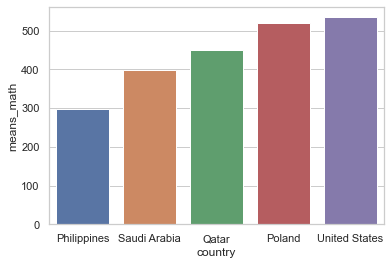

In [77]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(x="country", y="means_math", data=dfplt)

# Uncomment the next line to save plot as png file
# plt.savefig('means_plot.png')

In [68]:
tdf.sort_values('means_math')[:10]

idcntry  iso       country  means_math  means_science
39      608  PHL   Philippines  296.675151     249.018102
38      586  PAK      Pakistan  327.690538     290.096519
48      710  ZAF  South Africa  373.564479     324.233623
28      414  KWT        Kuwait  383.317867     392.295142
33      504  MAR       Morocco  383.387988     374.065693
44      682  SAU  Saudi Arabia  398.093120     402.236941
34      512  OMN          Oman  430.873616     434.944292
9       152  CHL         Chile  440.972393     469.115799
21      364  IRN         Iran,  443.035003     440.828043
27      411  XKX        Kosovo  444.353682     413.059390

In [87]:
# To compare math and science results we need to reshape our df using melt function (seaborn needs the data in the long format)
dfplt=dfplt[['iso','means_math','means_science']]
dfplt = pd.melt(dfplt, id_vars="iso", var_name="subject", value_name="result")

In [88]:
dfplt

iso        subject      result
0  PHL     means_math  296.675151
1  SAU     means_math  398.093120
2  QAT     means_math  449.412015
3  POL     means_math  520.139628
4  USA     means_math  534.732402
5  PHL  means_science  249.018102
6  SAU  means_science  402.236941
7  QAT  means_science  449.471959
8  POL  means_science  530.832808
9  USA  means_science  538.642607

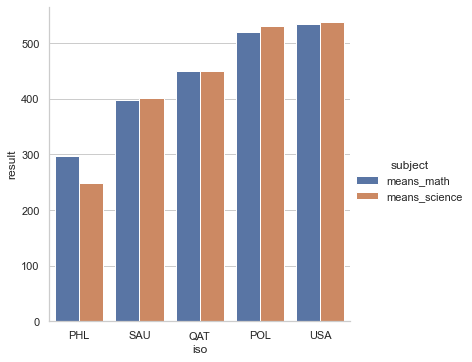

In [91]:
sns.catplot(x='iso', y='result', hue='subject', data=dfplt, kind='bar')

# Uncomment the next line to save plot as png file
# plt.savefig('math_vs_science_plot.png')

In [51]:
# perc and itsex

In [13]:
globbed_files = glob.glob(path+'T2019_gr4_p*') #creates a list of all dta files

In [14]:
data = [] # pd.concat takes a list of dataframes as an agrument
for dta in globbed_files:
    frame = pd.read_stata(dta)
    frame['percentile'] = os.path.basename(dta)[10:13]
    data.append(frame)

df = pd.concat(data, ignore_index=True)

In [15]:
df.head()

idcntry                                             asbg03  idgrade  \
0        8          I always speak <language of test> at home  Grade 4   
1        8   I almost always speak <language of test> at home  Grade 4   
2        8  I sometimes speak <language of test> and somet...  Grade 4   
3        8           I never speak <language of test> at home  Grade 4   
4        8                                                NaN  Grade 4   

  itlang_sq   itsex  asbgsec  asbghrl  asbgscs  asbgsls  asbgscm   asbgics  \
0  Albanian  Female      NaN  6.70211  8.47893  9.17441  8.48743  10.40151   
1  Albanian  Female      NaN  6.70211  8.33202  9.45888  8.30222  10.40151   
2  Albanian  Female      NaN  7.39134  8.61225  9.79069  8.66992   9.51083   
3  Albanian  Female      NaN  5.92097  8.18638  8.92203  8.66992  12.14438   
4  Albanian  Female      NaN  6.70211  7.91850  8.05308  7.74808   8.32500   

   asbgslm    asbgsb   asbgssb   asbgicm  asbgdml        math        scie  \
0  9.72723   9.54836  10.71074  10.36648  8.89281  384.285034  387.548889   
1  9.51007   8.83393  10.71074  10.36648  8.89281  391.135864  387.504547   
2  9.51007   8.64712   9.69880   9.40649  8.31475  421.849396  408.286743   
3  9.72723  10.33461  12.75064  12.25706  9.90339  389.535095  437.743347   
4  8.95513   8.16227   8.10425   9.40649  8.22700  236.543320  236.112793   

  percentile  
0        p10  
1        p10  
2        p10  
3        p10  
4        p10

In [6]:
df.to_csv('./out/timss_dash.csv')

In [16]:
df.rename(columns={'scie':'science','idgrade':'grade','asbg03':'home language','itsex':'gender','asbgsec':'self-efficacy for computer use','asbghrl':'home resources for learning','asbgscs':'confident in science','asbgsls':'like learning science','asbgscm':'confident in math','asbgics':'instructional clarity in science lessons','asbgslm':'like learning math','asbgsb':'bullying','asbgssb':'sense of school belonging','asbgicm':'instructional clarity in math','asbgdml':'disorderly behavior during math lessons'},inplace=True)

In [17]:
df.columns

Index(['idcntry', 'home language', 'grade', 'itlang_sq', 'gender',
       'self-efficacy for computer use', 'home resources for learning',
       'confident in science', 'like learning science', 'confident in math',
       'instructional clarity in science lessons', 'like learning math',
       'bullying', 'sense of school belonging',
       'instructional clarity in math',
       'disorderly behavior during math lessons', 'math', 'science',
       'percentile'],
      dtype='object')

In [18]:
df_melted = pd.melt(df, id_vars=["idcntry", "gender", "percentile", "home language", "grade"], value_vars=["math","science",'self-efficacy for computer use', 'home resources for learning',
       'confident in science', 'like learning science', 'confident in math',
       'instructional clarity in science lessons', 'like learning math',
       'bullying', 'sense of school belonging',
       'instructional clarity in math',
       'disorderly behavior during math lessons'],var_name="variable",value_name="score")

In [19]:
df_melted.rename(columns={'asbgsec':'self-efficacy for computer use','asbghrl':'home resources for learning','asbgscs':'confident in science','asbgsls':'like learning science','asbgscm':'confident in math','asbgics':'instructional clarity in science lessons','asbgslm':'like learning math','asbgsb':'bullying','asbgssb':'sense of school belonging','asbgicm':'instructional clarity in math','asbgdml':'disorderly behavior during math lessons'},inplace=True)

In [20]:
# We need to merge our df with a codebook including country names
idcntry=pd.read_csv(path+'idcntry.csv', sep=';')
df_melted=df_melted.merge(idcntry,on='idcntry')

In [21]:
df_melted=df_melted.dropna(subset=['score'])

In [22]:
df_melted.head()

idcntry  gender percentile  \
0        8  Female        p10   
1        8  Female        p10   
2        8  Female        p10   
3        8  Female        p10   
4        8  Female        p10   

                                       home language    grade variable  \
0          I always speak <language of test> at home  Grade 4     math   
1   I almost always speak <language of test> at home  Grade 4     math   
2  I sometimes speak <language of test> and somet...  Grade 4     math   
3           I never speak <language of test> at home  Grade 4     math   
4                                                NaN  Grade 4     math   

        score  country  iso  
0  384.285034  Albania  ALB  
1  391.135864  Albania  ALB  
2  421.849396  Albania  ALB  
3  389.535095  Albania  ALB  
4  236.543320  Albania  ALB

In [23]:
df_melted['home language']=np.where(df_melted['home language'].isna(),'No data',df_melted['home language'])

In [24]:
df_melted

idcntry  gender percentile  \
0             8  Female        p10   
1             8  Female        p10   
2             8  Female        p10   
3             8  Female        p10   
4             8  Female        p10   
...         ...     ...        ...   
113016      956    Male        p90   
113017      956    Male        p90   
113018      956    Male        p90   
113019      956    Male        p90   
113020      956    Male        p90   

                                            home language    grade  \
0               I always speak <language of test> at home  Grade 4   
1        I almost always speak <language of test> at home  Grade 4   
2       I sometimes speak <language of test> and somet...  Grade 4   
3                I never speak <language of test> at home  Grade 4   
4                                                 No data  Grade 4   
...                                                   ...      ...   
113016          I always speak <language of test> at home  Grade 4   
113017   I almost always speak <language of test> at home  Grade 4   
113018  I sometimes speak <language of test> and somet...  Grade 4   
113019           I never speak <language of test> at home  Grade 4   
113020                                            No data  Grade 4   

                                       variable       score  country  iso  
0                                          math  384.285034  Albania  ALB  
1                                          math  391.135864  Albania  ALB  
2                                          math  421.849396  Albania  ALB  
3                                          math  389.535095  Albania  ALB  
4                                          math  236.543320  Albania  ALB  
...                                         ...         ...      ...  ...  
113016  disorderly behavior during math lessons   11.687870  Belgium  BFL  
113017  disorderly behavior during math lessons   11.194450  Belgium  BFL  
113018  disorderly behavior during math lessons   11.194450  Belgium  BFL  
113019  disorderly behavior during math lessons   10.799760  Belgium  BFL  
113020  disorderly behavior during math lessons   11.687870  Belgium  BFL  

[97578 rows x 9 columns]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Control',
    x=['Trial 1', 'Trial 2', 'Trial 3'], y=[3, 6, 4],
    error_y=dict(type='data', array=[1, 0.5, 1.5])
))
fig.add_trace(go.Bar(
    name='Experimental',
    x=['Trial 1', 'Trial 2', 'Trial 3'], y=[4, 7, 3],
    error_y=dict(type='data', array=[0.5, 1, 2])
))
fig.update_layout(barmode='group')
fig.show()

In [181]:
df_melted.to_csv('./out/timss_means.csv')